In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import networkx.algorithms.community as nxc
import statistics
import scipy.stats as stats
import os
from datetime import datetime, date, timedelta
import pickle
import warnings
import json
import random as random

warnings.simplefilter(action='ignore', category=FutureWarning)

This takes the temporal networks generated from temporal network extraction. Note that duration is in seconds but start and end are in frames. Tracking data was collected at 6fps

In [7]:
# Set working directory and open list of myrmidon files

working_dir = '/media/ll16598/One Touch/NTM'
myrm_list = sorted([ s for s in os.listdir(working_dir+'/duration_temporal_networks') if s[15:17] == '_z'])

In [9]:
G_list=[]
names=[]

frame_rate = 6  # 6 frames per second

for g in range(0,len(myrm_list)):
    name=myrm_list[g]
    G=nx.read_graphml(working_dir+'/duration_temporal_networks/'+myrm_list[g])
    for u, v, data in G.edges(data=True):
        if 'interaction' in data:
            data['interaction'] = json.loads(data['interaction'])
        try:
            data['interaction']['start'] = data['interaction']['start'] / frame_rate
            data['interaction']['end'] = data['interaction']['end'] / frame_rate
        except TypeError:
            pass
    G_list.append(G)
    names.append(name)
    print(name)

EG_NTM_s13_DEHa_zones_luke_2023_nn.myrmidon_graph.xml


KeyboardInterrupt: 

In [17]:
def create_active_subgraph(G, time_point):
    active_edges = []

    for u, v, key, data in G.edges(data=True, keys=True):
        start_time = data['interaction']['start']
        end_time = data['interaction']['end']

        if start_time <= time_point <= end_time:
            # Add the edge with its key
            active_edges.append((u, v, key))
    active_subgraph = G.edge_subgraph(active_edges)
    return active_subgraph

def consensus_update(G):
    # Create a copy of the graph to update node attributes
    G_updated = G.copy()

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        # Sum of votes of the neighbors
        vote_sum = sum(G.nodes[neighbor]['vote'] for neighbor in neighbors)
        # Determine the new vote based on majority
        if len(neighbors) > 0:
            if vote_sum > len(neighbors) / 2:
                G_updated.nodes[node]['vote'] = 1
            elif vote_sum < len(neighbors) / 2:
                G_updated.nodes[node]['vote'] = 0
            # For tie cases, you can decide to keep the current state, change it, or handle it differently

    return G_updated

def update_main_graph(G, G_updated):
    # Iterate over the nodes in the updated subgraph
    for node in G_updated.nodes():
        # Update the 'vote' attribute in the main graph G
        if node in G:
            G.nodes[node]['vote'] = G_updated.nodes[node]['vote']
    return G

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [18]:
dir_save=working_dir+'/transmission_simulation_results/'

In [35]:
time_point = 200
active_subgraph = create_active_subgraph(G, time_point)
G_updated = consensus_update(active_subgraph)
G = update_main_graph(G, G_updated)


In [19]:
simulation_duration_hr=23#We use 23 not 24 since the full span is 24, and we start smoewhere in the first hour
num_inoculated=1 #how many to initialise the simulation
duration_seconds = 3600  # 1 hour
beta=np.mean([0.39, 0.36, 0.24]) #stroeymeyt 2018
sigma=0.00024
transmission_rate=0.00138#/4
dataframes=[]
l=0
iterations=200
it=0
while it< iterations:
    g=0
    while g <len(G_list):
        G=G_list[g].copy()
        name=names[g]
        #We sort edges by time for the temporal network
        edges_sorted_by_time = sorted(G.edges(data=True), key=lambda x: x[2]['interaction']['start'])
        #first we need to find all edges in the first hour which are in the entrance chamber (zone3)
        first_second= edges_sorted_by_time[0][2]['interaction']['start']
        final_second= edges_sorted_by_time[len(edges_sorted_by_time)-1][2]['interaction']['end']
        end_second_first_hour = edges_sorted_by_time[0][2]['interaction']['start']+duration_seconds
        edges_in_first_hour_zone_3 = []
        for u, v, data in G.edges(data=True):
            start_s = data['interaction']['start']
            end_s = data['interaction']['end']
            zone = data['interaction']['zone']
            # Check if the edge is within the first hour and in zone 3, the entrance chamber
            if (start_s < end_second_first_hour) and zone == 3:
                edges_in_first_hour_zone_3.append((u, v, data))
        min_time=500000000
        inoc_count=0
        inoculated_nodes=[]
        while inoc_count<num_inoculated:
            edge_epi_start=random.choice(edges_in_first_hour_zone_3)
            inoculated_node=random.choice([edge_epi_start[0], edge_epi_start[1]])
            if inoculated_node in inoculated_nodes:
                continue
            G.nodes[inoculated_node]['pathogen_load'] = 1
            if edge_epi_start[2]['interaction']['start']<min_time:
                min_time=edge_epi_start[2]['interaction']['start']  
            inoc_count+=1
            inoculated_nodes.append(inoculated_node)
        time_simulation_start=min_time
        time_simulation_end=time_simulation_start+(3600*simulation_duration_hr)
        gini_coefficients = []
        prevalences = []
        mean_loads = []
        entropies = []
        median_loads=[]
        prevalences_hi=[]
        dts=[]
        for u, v, data in edges_sorted_by_time:
            start_s = data['interaction']['start']
            # Check if the edge's start time is within the simulation period
            if time_simulation_start <= start_s < time_simulation_end:
                G, changed =transmit(G, u, v, data, beta, sigma, transmission_rate)
            else:
                continue
            if changed:
                dt=start_s-time_simulation_start
                dts.append(dt)
                pathogen_loads = np.array([G.nodes[n]['pathogen_load'] for n in G.nodes])
                pathogen_loads_non = np.array([G.nodes[n]['pathogen_load'] for n in G.nodes if n not in inoculated_nodes])
                entropies.append(stats.entropy(pathogen_loads))
                gini_coefficients.append(gini_coefficient(pathogen_loads))
                prevalences.append(len([i for i in pathogen_loads if i > sigma])/len(pathogen_loads))
                mean_loads.append(np.mean(pathogen_loads_non))
                median_loads.append(np.median(pathogen_loads_non))
                prevalences_hi.append(len([i for i in pathogen_loads if i > 0.048])/len(pathogen_loads))
        df = pd.DataFrame({
        'dt':dts,
        'gini_coefficients': gini_coefficients,
        'prevalences': prevalences,
        'entropies': entropies,
        'mean_loads': mean_loads,
        'median_loads':median_loads,
        'prevalences_hi':prevalences_hi,
        'names': [name for i in range(0,len(prevalences))],
        'condition':[name[11:15]  for i in range(0,len(prevalences))],
        'initial_inoculated':[num_inoculated for i in range(0,len(prevalences))],
        'run': [l for i in range(0,len(prevalences))],
        'iteration': [it for i in range(0,len(prevalences))]
        })
        
        #restart if does not worj
        if len(df)==0:
            g-=1
            continue
        l+=1
        g+=1
        dataframes.append(df.iloc[-1])
        print('completed transmission simulation over', name)
        df.to_csv(dir_save+name+'_'+str(it)+'.csv')    
    print('Completed iteration:', it)
    it+=1
    
overall_df=pd.concat(dataframes)
overall_df.to_csv(dir_save+'/'+str(it)+'iterations_aggregated_final_results.csv') 

completed transmission simulation over EG_NTM_s13_DEHa_zones_luke_2023_nn.myrmidon_graph.xml


KeyboardInterrupt: 

In [215]:
overall_df=pd.concat(dataframes)


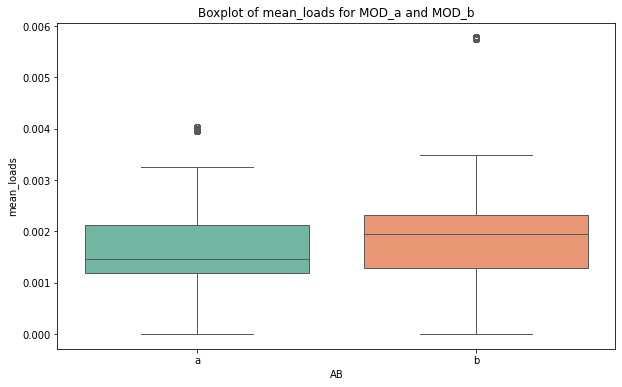

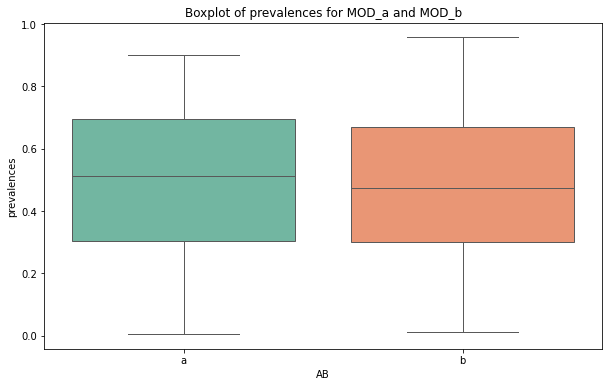

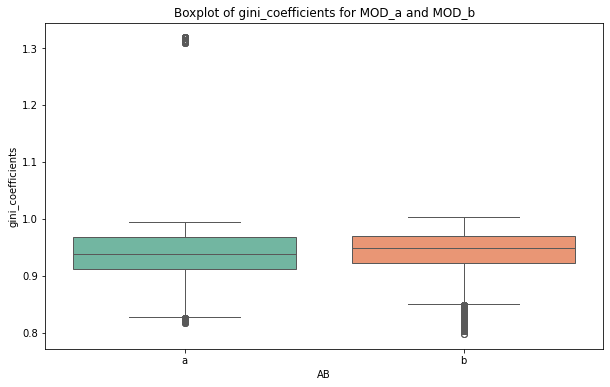

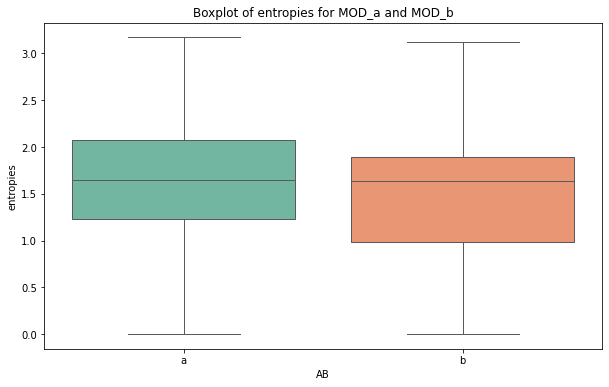

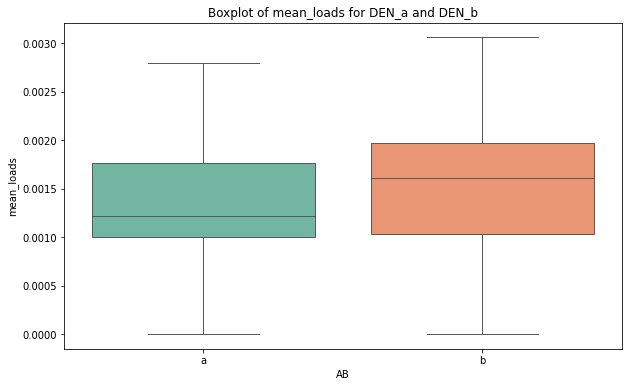

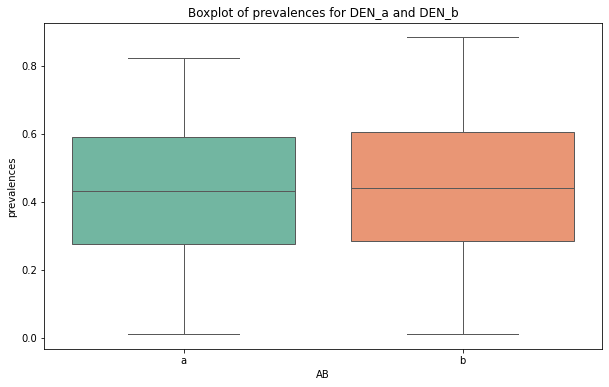

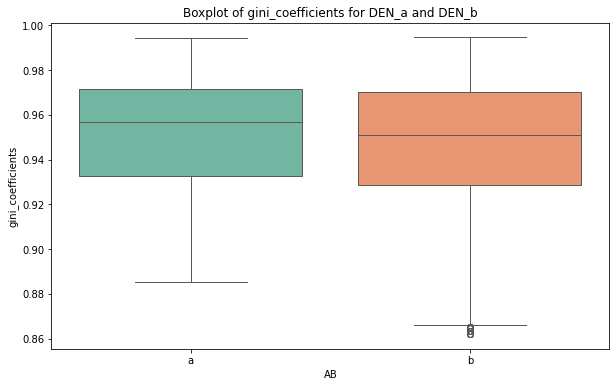

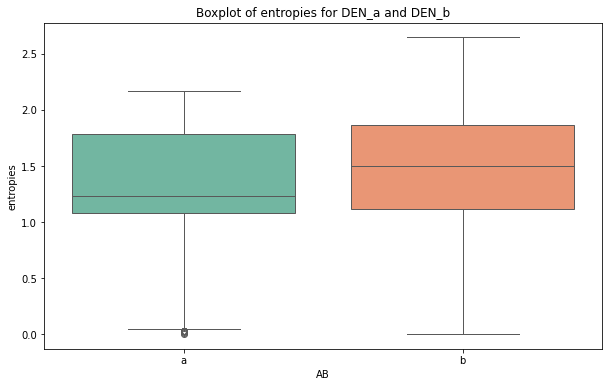

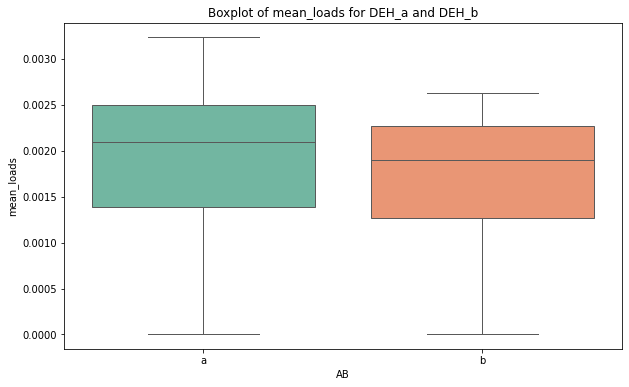

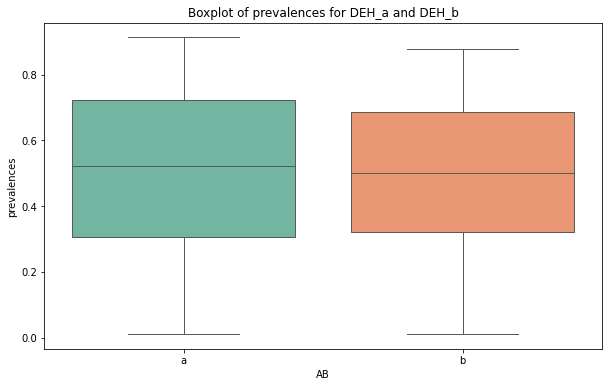

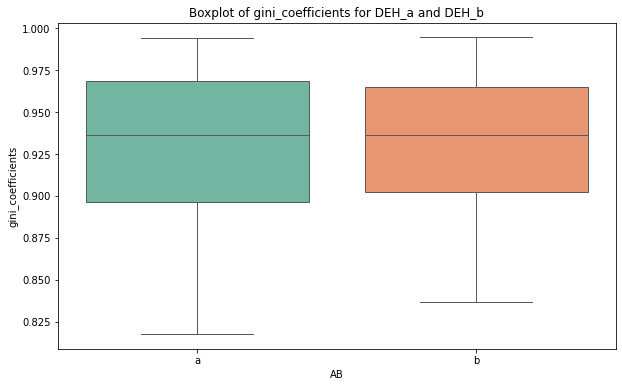

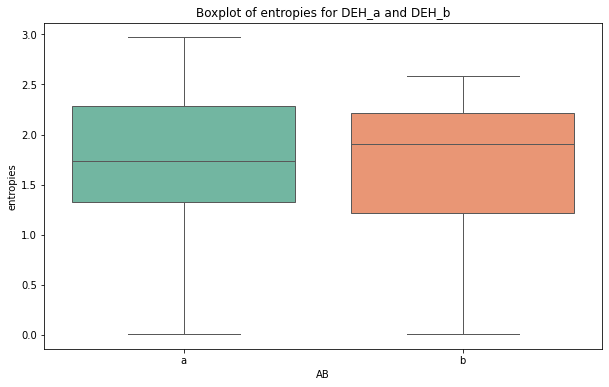

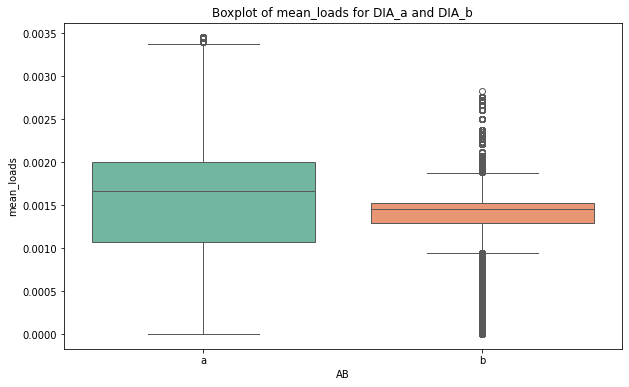

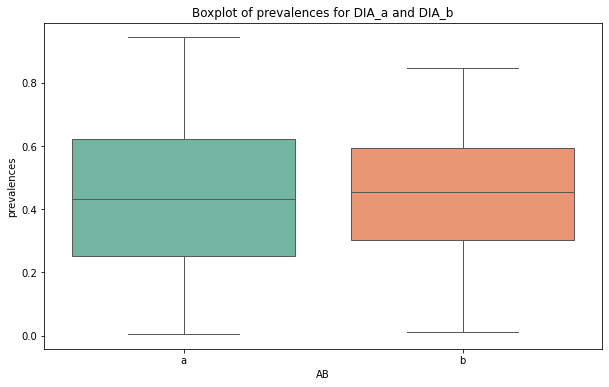

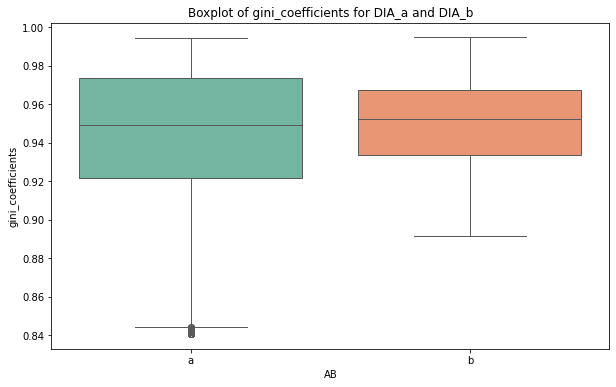

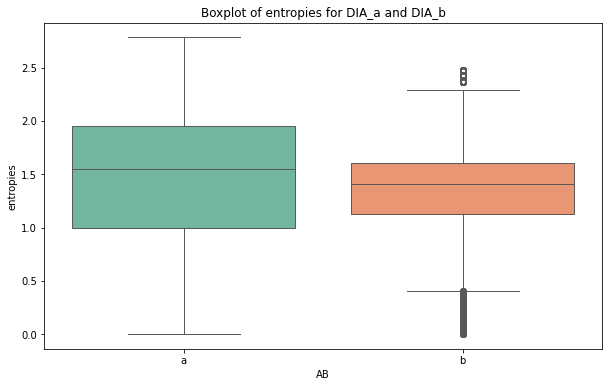

In [216]:
net_properties=['MOD', 'DEN', 'DEH', 'DIA']
transmission_params=['mean_loads', 'prevalences', 'gini_coefficients', 'entropies' ]

# Loop through each combination and create a boxplot
for net_property in net_properties:
    for transmission_param in transmission_params:
        plot_df = overall_df[overall_df['condition'].str.contains(net_property, na=False)].reset_index(drop=True)
        plot_df['AB'] = plot_df['condition'].apply(lambda x: 'a' if 'a' in x else ('b' if 'b' in x else 'other'))

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='AB', y=transmission_param, data=plot_df, hue='AB', palette="Set2")
        plt.title(f'Boxplot of {transmission_param} for {net_property}_a and {net_property}_b')
        plt.ylabel(transmission_param)
        plt.show()